# Implement Simple neural networks using python
### Implementation of different activation functions used in DL models 
### Implementation of simple neural network for and/or/xor operations using basic python
### Implement ANN model for prediction for dataset and comparative analysis of ANN model and ML model result

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

np.random.seed(42)
tf.random.set_seed(42)

In [16]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

x_demo = np.array([-2.0, -1.0, 0.0, 1.0, 2.0])
print("sigmoid:", sigmoid(x_demo))
print("tanh:", tanh(x_demo))
print("relu:", relu(x_demo))
print("leaky_relu:", leaky_relu(x_demo))
print("softmax:", softmax(x_demo))

sigmoid: [0.11920292 0.26894142 0.5        0.73105858 0.88079708]
tanh: [-0.96402758 -0.76159416  0.          0.76159416  0.96402758]
relu: [0. 0. 0. 1. 2.]
leaky_relu: [-0.02 -0.01  0.    1.    2.  ]
softmax: [0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]


In [17]:
def train_perceptron(X, y, lr=0.1, epochs=20):
    w = np.zeros(X.shape[1] + 1)
    for _ in range(epochs):
        for xi, yi in zip(X, y):
            y_hat = 1 if (np.dot(w[1:], xi) + w[0]) >= 0 else 0
            update = lr * (yi - y_hat)
            w[1:] += update * xi
            w[0] += update
    return w

def predict_perceptron(X, w):
    return np.array([1 if (np.dot(w[1:], xi) + w[0]) >= 0 else 0 for xi in X])

X_logic = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_and = np.array([0, 0, 0, 1])
y_or = np.array([0, 1, 1, 1])

w_and = train_perceptron(X_logic, y_and)
w_or = train_perceptron(X_logic, y_or)

print("AND predictions:", predict_perceptron(X_logic, w_and))
print("OR predictions:", predict_perceptron(X_logic, w_or))

AND predictions: [0 0 0 1]
OR predictions: [0 1 1 1]


In [18]:
def sigmoid_deriv(s):
    return s * (1 - s)

X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor = np.array([[0], [1], [1], [0]])

W1 = np.random.randn(2, 2)
b1 = np.zeros((1, 2))
W2 = np.random.randn(2, 1)
b2 = np.zeros((1, 1))

lr = 0.5
for _ in range(10000):
    z1 = np.dot(X_xor, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = sigmoid(z2)

    error = y_xor - a2
    d2 = error * sigmoid_deriv(a2)
    d1 = np.dot(d2, W2.T) * sigmoid_deriv(a1)

    W2 += lr * np.dot(a1.T, d2)
    b2 += lr * np.sum(d2, axis=0, keepdims=True)
    W1 += lr * np.dot(X_xor.T, d1)
    b1 += lr * np.sum(d1, axis=0, keepdims=True)

xor_pred = (a2 > 0.5).astype(int)
print("XOR predictions:", xor_pred.ravel())

XOR predictions: [0 0 1 1]


In [19]:
df = pd.read_csv("diabetes.csv")
df = df.dropna()

target_col = "Outcome" if "Outcome" in df.columns else df.columns[-1]
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if y.nunique() > 1 else None
 )

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ann = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])
ann.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = ann.fit(X_train_scaled, y_train, epochs=50, batch_size=16, verbose=0)

ann_probs = ann.predict(X_test_scaled, verbose=0).ravel()
ann_pred = (ann_probs >= 0.5).astype(int)

ml = LogisticRegression(max_iter=1000)
ml.fit(X_train_scaled, y_train)
ml_pred = ml.predict(X_test_scaled)

avg = "binary" if y.nunique() == 2 else "weighted"

def metrics_row(name, y_true, y_pred):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average=avg, zero_division=0),
        "Recall": recall_score(y_true, y_pred, average=avg, zero_division=0),
        "F1": f1_score(y_true, y_pred, average=avg, zero_division=0),
    }

results = pd.DataFrame([
    metrics_row("ANN (TensorFlow)", y_test, ann_pred),
    metrics_row("ML (LogisticRegression)", y_test, ml_pred),
])
print(results)

                     Model  Accuracy  Precision    Recall        F1
0         ANN (TensorFlow)  0.746753   0.647059  0.611111  0.628571
1  ML (LogisticRegression)  0.714286   0.608696  0.518519  0.560000


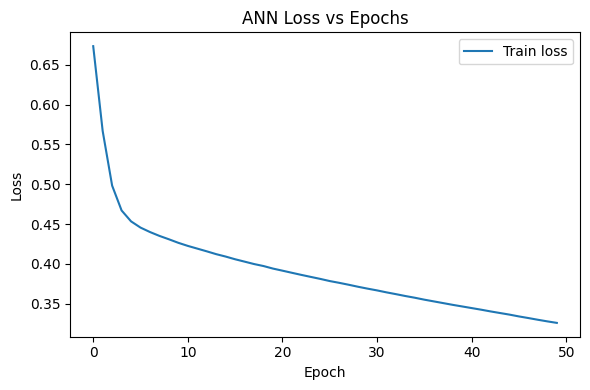

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Train loss")
plt.title("ANN Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()